In [1]:
import numpy as np
import uproot
import h5py
import os
import torch
import torch_geometric.nn as PyG
from torch_geometric.transforms import Distance
from torch_geometric.data import InMemoryDataset as PyGDataset, Data as PyGData
from torch_geometric.data import Data
import math
import numba
import numpy as np
import torch
import h5py
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as PyG
from torch_geometric.transforms import Distance
from torch_geometric.data import DataLoader
from torch_geometric.data import Data as PyGData
from torch_geometric.data import Data
import sys, os
import subprocess
import csv, yaml
import math
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.optim as optim
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
# import numpy, numba, awkward, awkward.numba

In [2]:

# path = '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex2/220323_084833/delphes'
# graph_path = '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex2/220323_084833/graph/'
# output_path = '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex2/220323_084833/h5/'


path = '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes'
graph_path = '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/graph/'
output_path = '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/h5/'


# path = '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes'
# graph_path = '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/*/*/graph/4top_ex1_8*.h5'
# output_path = '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/*/*/h5/'



In [3]:
resampling_model = '/users/yewzzang/work/HEPGNN_4top_resampling/result/20220411_4top_run1'

In [4]:
sys.path.append("./python")

In [5]:
from model.allModel import *

model = torch.load(resampling_model+'/model.pth', map_location='cpu')
model.load_state_dict(torch.load(resampling_model+'/weight.pth', map_location='cpu'))
model = model.cuda()
device = 'cuda'

In [6]:
model

GCN3(
  (conv1): GCNConv(4, 32)
  (conv2): GCNConv(32, 64)
  (conv3): GCNConv(64, 64)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Softplus(beta=1, threshold=20)
  )
)

In [7]:
@numba.njit(nogil=True, fastmath=True, parallel=True)
def buildGraph(jetss_pt, jetss_eta, jetss_phi):
#     maxDR2 = 100
    maxDR2 = 0 ## maximum deltaR value to connect two jets
    graphs = []
    g = []
    
    selJets = (jetss_pt > 35) & (np.fabs(jetss_eta) < 2.4)

    jets_eta = jetss_eta[selJets]
    jets_phi = jetss_phi[selJets]
#     jets_eta = jetss_eta
#     jets_phi = jetss_phi
    
    nJet = len(jets_eta)
    prange = numba.prange
    for i in prange(nJet):
        for j in prange(i):
#     for i in range(nJet):
#         for j in range(i):
            dEta = jets_eta[i]-jets_eta[j]
            dPhi = jets_phi[i]-jets_phi[j]
            ## Move dPhi to [-pi,pi] range
            if   dPhi >= math.pi: dPhi -= 2*math.pi
            elif dPhi < -math.pi: dPhi += 2*math.pi
            ## Compute deltaR^2 and ask it is inside of our ball
            dR2 = dEta*dEta + dPhi*dPhi
            if dR2 > maxDR2: continue
            g.append([i,j])
            
    graphs.append(g)
    return graphs

In [8]:
def countNBjets(JetBTag):
    nEvent = int(len(JetBTag))
    NBjets = []
    for i in range(nEvent):
        selBjets = (JetBTag[i] > 0.5)
        numBjets = np.sum(selBjets)
        NBjets.append(numBjets)
    return np.array(NBjets, dtype=np.dtype('int64'))

In [9]:
res = []
for root, dirs, files in os.walk(path):
    rootpath = os.path.join(os.path.abspath(path), root)
    for file in files:
        filepath = os.path.join(rootpath, file)
        
        filetype = filepath.split('.')[-1]
        if filetype != 'root': continue
  
        res.append(filepath)

In [10]:
res

['/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes/4top_ex1_delphes_93.root',
 '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes/4top_ex1_delphes_2.root',
 '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes/4top_ex1_delphes_6.root',
 '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes/4top_ex1_delphes_28.root',
 '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes/4top_ex1_delphes_41.root',
 '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes/4top_ex1_delphes_91.root',
 '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes/4top_ex1_delphes_5.root',
 '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes/4top_ex1_delphes_85.root',
 '/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1

In [11]:
res = ['/users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/delphes/4top_ex1_delphes_93.root']

In [12]:
import time
preds = []
f_weight_list = []
start = time.time()
for i in range(len(res)):

    file_name = res[i]
    cla = file_name.split('/')[-4].split('_')
    num = file_name.split('/')[-1].split('.')[-2]

    

    save_f_name = num

    save_path = output_path
    if not os.path.exists(save_path): os.makedirs(save_path)
    save_file_name = save_path + save_f_name + '.pt'
#     print(save_file_name)
### load data
    try:
        r_data = uproot.open(file_name)["Delphes"] 
#     r_data = uproot.open(file_name)["Delphes"]
    except KeyError:
        print("delphes 없음")
        pass
    
    
    
    graph_file = graph_path + num.split('_')[0]+'_'+num.split('_')[1]+'_'+num.split('_')[3] + '.h5'
    
    
    
    f = h5py.File(graph_file,'r')
    nEvent = len(f['events']['m'])
    f_m = f['events']['m']
    f_px = f['events']['px']
    f_py = f['events']['py']
    f_pz = f['events']['pz']
    f_id = f['events']['id']
    f_weight = f['events']['weight']


    f_edge1 = f['graphs']['edge1']
    f_edge2 = f['graphs']['edge2']
    f_fea_list = []
    f_edge_list = []
    
    for j in range(nEvent):
        f_fea_reshape = torch.cat((torch.from_numpy(f_m[j]).reshape(-1,1),torch.from_numpy(f_px[j]).reshape(-1,1),torch.from_numpy(f_py[j]).reshape(-1,1),torch.from_numpy(f_pz[j]).reshape(-1,1)),1).float()   


        f_edge_reshape = torch.cat((torch.from_numpy(f_edge1[j]).reshape(1,-1),torch.from_numpy(f_edge2[j]).reshape(1,-1)),0).float()

        f_fea_list.append(f_fea_reshape)

        f_edge_list.append(f_edge_reshape)
        f_weight_list.append(f_weight[i])
    
    
    
    Muon_size = np.asarray(r_data["Muon_size"])
    Elec_size = np.asarray(r_data["Electron_size"])
    
    JetPt = np.asarray(r_data["Jet.PT"])
    JetEta = np.asarray(r_data["Jet.Eta"])
    JetPhi = np.asarray(r_data["Jet.Phi"])
    JetMass = np.asarray(r_data["Jet.Mass"])
    JetBTag = np.asarray(r_data["Jet.BTag"])
    
    FMass = np.asarray(r_data["FatJet.Mass"])
    FPt = np.asarray(r_data["FatJet.PT"])
    FEta = np.asarray(r_data["FatJet.Eta"])

    
    pos = []
    x_fea = []
    edge_t = []

    datalist = []
    model.eval()
    
    ## make data    
    for j in range(len(FPt)):
        
        ### selection
        

        numLepton = (Muon_size[j] + Elec_size[j])
        if numLepton > 0 : continue
            
        selJets = (JetPt[j] > 35) & (np.fabs(JetEta[j]) < 2.4)
        if np.sum(selJets) < 9: continue 
        ht = np.sum(JetPt[j][selJets])
        if  ht < 700: continue
        
        ##### make resampling weith
        
        feats = torch.Tensor(f_fea_list[j])
        edges = torch.Tensor(f_edge_list[j])
        edges = edges.type(dtype=torch.long)
        
 
        
        data = PyGData(x = feats, edge_index = edges, batch = torch.from_numpy(np.zeros([len(feats)],dtype = np.int)))

        data = data.to(device)
        pred = model(data)
        
        preds.append(torch.tensor(pred).cpu())
#     print(graph_file,'finish')

# print(time.time()-start)

/users/yewzzang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [13]:
import matplotlib.pyplot as plt

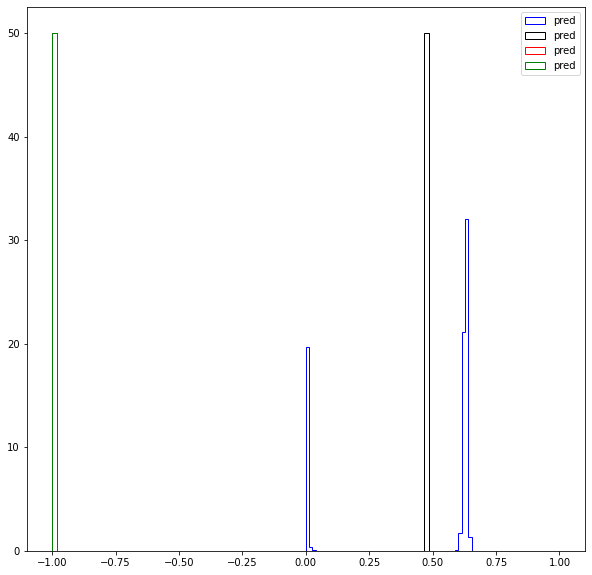

In [16]:
plt.figure(figsize=(10,10))



plt.hist(torch.tensor(preds).reshape(1,-1), histtype='step', density=True, bins=50, color='blue',label='pred')        
plt.hist(np.average(torch.tensor(preds)).reshape(1,-1), histtype='step', density=True, bins=50, color='black',label='pred')        


plt.hist((torch.tensor(f_weight_list)/torch.abs(torch.tensor(f_weight_list))).reshape(1,-1), histtype='step', density=True, bins=50, color='red',label='pred')        
plt.hist(np.average((torch.tensor(f_weight_list)/torch.abs(torch.tensor(f_weight_list))).reshape(1,-1)), histtype='step', density=True, bins=50, color='green',label='pred')        


plt.legend()
plt.xlim([-1.1,1.1])

plt.show()

In [17]:
torch.tensor(f_weight_list)

tensor([-0.0220, -0.0220, -0.0220,  ..., -0.0220, -0.0220, -0.0220])